### Analyze intensity data from cardiac ultrasound

In [4]:
%reload_ext autoreload
%autoreload 2

In [49]:
# import dependencies

#data structure and io
import glob
import os
import pandas as pd

# general computation 
import numpy as np

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
from MCE.utils import custom_plots 

# signal processing 
from scipy.ndimage import gaussian_filter,gaussian_filter1d
from scipy import signal 
from scipy.fft import fft, fftfreq
from scipy import stats

save_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/figures/"

In [4]:
df = pd.read_csv("Y:/laura_berkowitz/cardiac_grant/burst_data/old_data/713_burst3_all.csv")
# df = df.loc[df["time after burst"] > 0, :]
df

,,time,time after burst,pw_ROI1,pw_ROI2,pw_ROI3,Mean_bmode,ventricle
0,1,0.020833,-6.729167,28.450,11.907,18.044,44.581,44.078
1,2,0.041667,-6.708333,19.079,10.423,13.489,45.205,33.871
2,3,0.062500,-6.687500,23.836,12.001,15.495,45.804,32.533
3,4,0.083333,-6.666667,36.586,20.158,18.916,46.692,49.466
4,5,0.104167,-6.645833,31.807,15.255,19.016,45.588,36.122
...,...,...,...,...,...,...,...,...
626,627,13.062500,6.312500,21.640,15.651,14.646,43.901,39.116
627,628,13.083333,6.333333,19.652,10.798,14.253,42.714,44.011
628,629,13.104167,6.354167,27.745,14.855,18.628,42.640,38.602
629,630,13.125000,6.375000,25.348,11.010,22.843,42.837,33.348


## For a single burst event, how does the intensity change across all ROIs

we'll also smooth the intensity to reduce the influence of known mediators (heartrate and respiration)

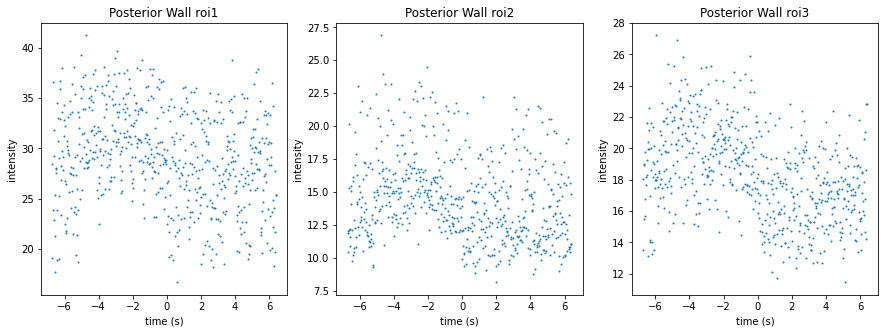

In [5]:
# scatter intensity over time
fig,axs = plt.subplots(1,3,figsize = (15,5))
axs.ravel()

axs[0].scatter(df["time after burst"],df["pw_ROI1"],s=1)
axs[1].scatter(df["time after burst"],df["pw_ROI2"],s=1)
axs[2].scatter(df["time after burst"],df["pw_ROI3"],s=1)

axs[0].set_title("Posterior Wall roi1")
axs[1].set_title("Posterior Wall roi2")
axs[2].set_title("Posterior Wall roi3")

for ax in axs:  
    ax.set_xlabel("time (s)")
    ax.set_ylabel("intensity")

There is no linear association with intensity over time, though there is some striations appearing. Intensity changes as a function of the cardiac cycle, so lets parse the data based on cylce position. 

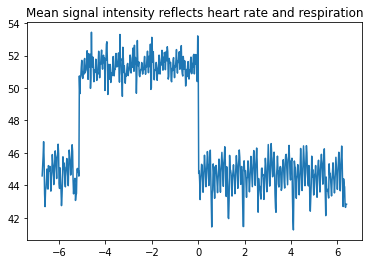

In [6]:
plt.plot(df["time after burst"],df["Mean_bmode"])
plt.title("Mean signal intensity reflects heart rate and respiration")
plt.show()

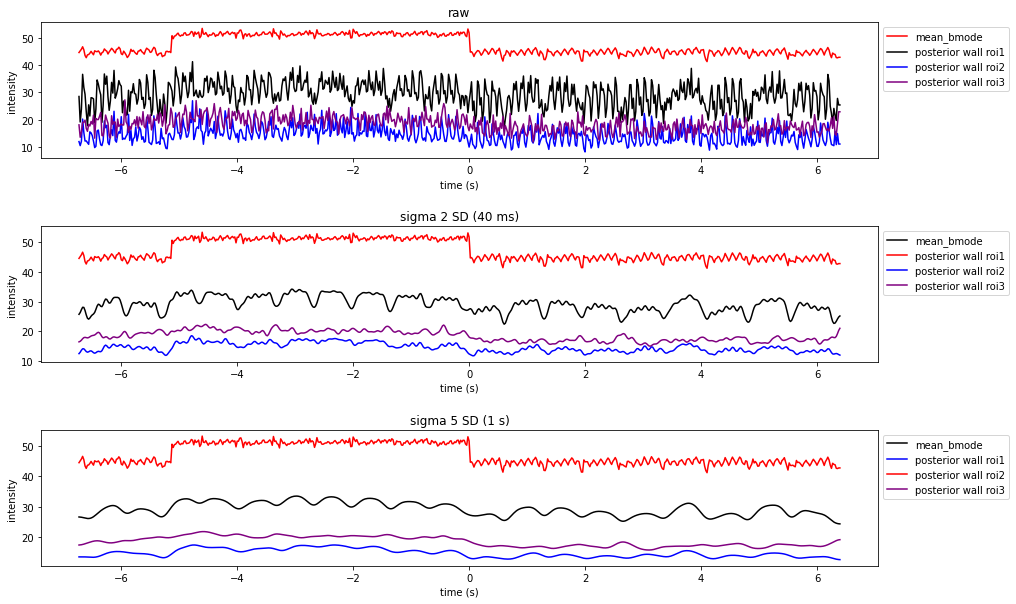

In [7]:
fig,axs = plt.subplots(3,1,figsize=(15,10))
axs.ravel()
fig.subplots_adjust(hspace = .5)

axs[0].plot(df["time after burst"],df.Mean_bmode,color = "r")
axs[0].plot(df["time after burst"],df.pw_ROI1,color = "k")
axs[1].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI1),2),color = "k")
axs[2].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI1),5),color = "k")

axs[1].plot(df["time after burst"],df.Mean_bmode,color = "r")
axs[0].plot(df["time after burst"],df.pw_ROI2,color = "blue")
axs[1].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI2),2),color = "blue")
axs[2].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI2),5),color = "blue")

axs[2].plot(df["time after burst"],df.Mean_bmode,color = "r")
axs[0].plot(df["time after burst"],df.pw_ROI3,color = "purple")
axs[1].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI3),2),color = "purple")
axs[2].plot(df["time after burst"],gaussian_filter(np.array(df.pw_ROI3),5),color = "purple")

# axs[0].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[1].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[2].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

axs[0].set_title("raw")
axs[1].set_title("sigma 2 SD (40 ms)")
axs[2].set_title("sigma 5 SD (1 s)")

for ax in axs:  
    ax.legend(["mean_bmode","posterior wall roi1","posterior wall roi2","posterior wall roi3","burst epoch"],bbox_to_anchor=(1,1),loc = "upper left",ncol=1)
    ax.set_xlabel("time (s)")
    ax.set_ylabel("intensity")

    plt.savefig(save_path+"smoothed_signal.svg",dpi = 300, bbox_inches = "tight")

### Normalize the intensity of ROI relative to mean intensity (meab_bmode)

additionally, lets average the posterior wall ROIs as they exhibited similar intensity changes over time

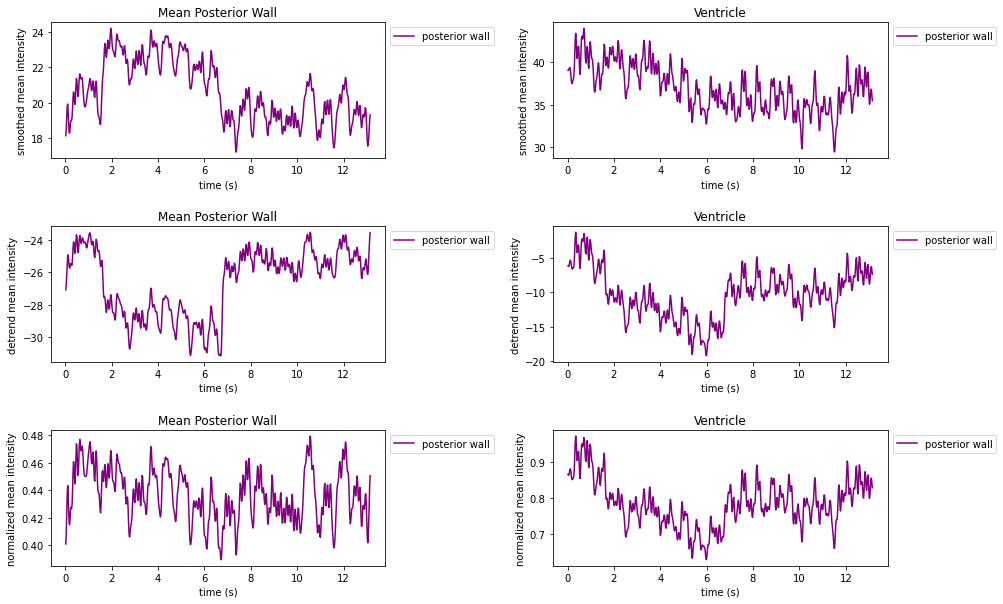

In [8]:
# compute data
cols = ['pw_ROI1','pw_ROI2','pw_ROI3']

prop_pw = df[cols].mean(axis=1)/df['Mean_bmode']  
prop_ventricle = np.array(df.ventricle/df.Mean_bmode)

detrend_pw = df[cols].mean(axis=1) - df['Mean_bmode']  
detrend_ventricle = np.array(df.ventricle - df.Mean_bmode)

smoothed_pw = df[cols].mean(axis=1) 
smoothed_ventricle = np.array(df.ventricle)


fig,axs = plt.subplots(3,2,figsize=(15,10))
axs = axs.ravel()
fig.subplots_adjust(hspace = .5,wspace = .5)

axs[0].plot(df.time,gaussian_filter(smoothed_pw,2),color = "purple")
axs[1].plot(df.time,gaussian_filter(smoothed_ventricle,2),color = "purple")

axs[2].plot(df.time,gaussian_filter(np.array(detrend_pw),2),color = "purple")
axs[3].plot(df.time,gaussian_filter(np.array(detrend_ventricle),2),color = "purple")

axs[4].plot(df.time,gaussian_filter(prop_pw,2),color = "purple")
axs[5].plot(df.time,gaussian_filter(prop_ventricle,2),color = "purple")


# axs[0].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[1].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

# axs[2].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[3].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

# axs[4].axvspan(df.time[71],df.time[312],alpha = .25,color='red')
# axs[5].axvspan(df.time[71],df.time[312],alpha = .25,color='red')

axs[0].set_title("Mean Posterior Wall")
axs[1].set_title("Ventricle")
axs[0].set_ylabel("smoothed mean intensity")
axs[1].set_ylabel("smoothed mean intensity")

axs[2].set_title("Mean Posterior Wall")
axs[3].set_title("Ventricle")
axs[2].set_ylabel("detrend mean intensity")
axs[3].set_ylabel("detrend mean intensity")

axs[4].set_title("Mean Posterior Wall")
axs[5].set_title("Ventricle")
axs[4].set_ylabel("normalized mean intensity")
axs[5].set_ylabel("normalized mean intensity")
for ax in axs:  
    ax.legend(["posterior wall","burst epoch"],bbox_to_anchor=(1,1),loc = "upper left",ncol=1)
    ax.set_xlabel("time (s)")


plt.savefig(save_path+"normalize_approach_burst_intensity.svg",dpi = 300, bbox_inches = "tight")

### Examine Intensity relative to phase of cardiac cylcle (Part 1)

We can estimate the time at  end-diastolic volumn by finding the peaks of oscillations from 5 - 13 Hz (corresponds to heart rates from around 300 - 800 BPM). 

NameError: name 'sns' is not defined

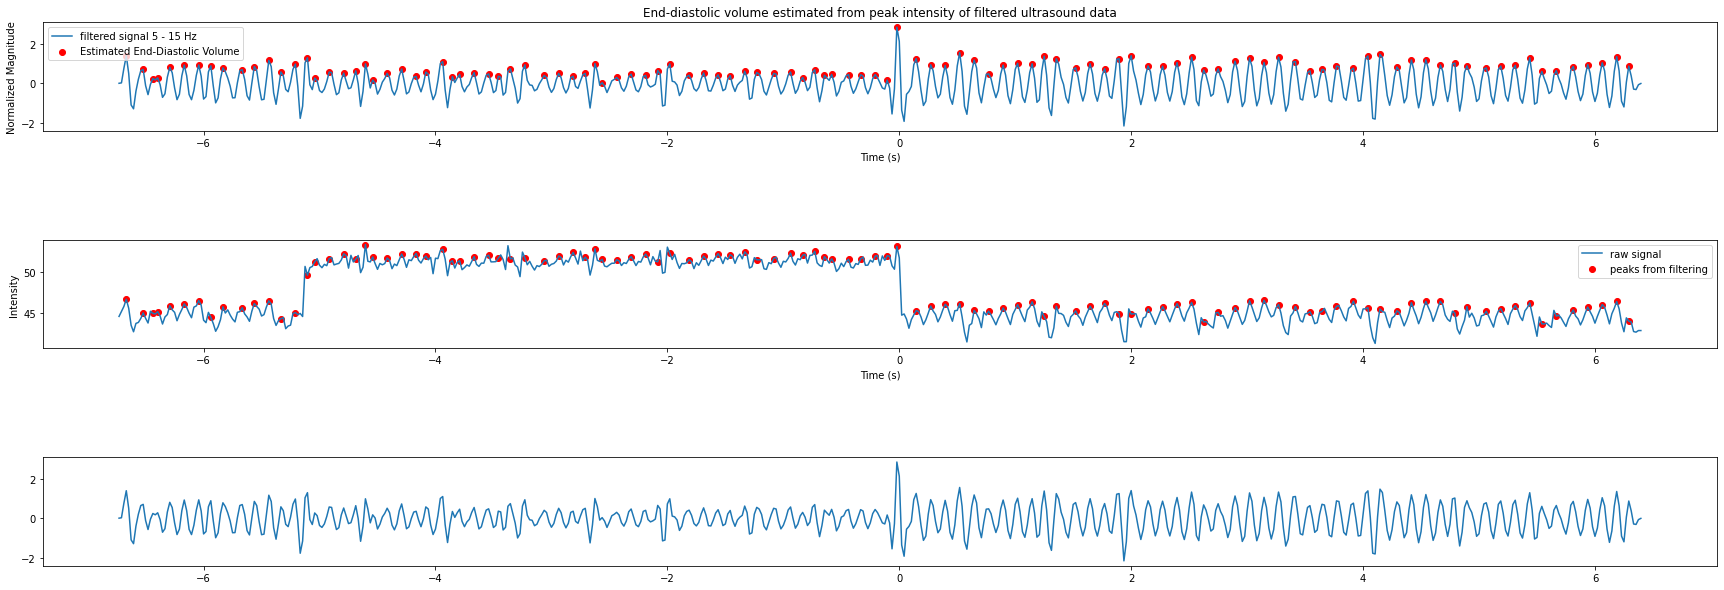

In [9]:
from scipy import signal 
from scipy.fft import fft, fftfreq
from scipy import stats

t = np.array(df["time after burst"])
sig = np.array(df.Mean_bmode)

hr, peak_locs, filt_sig = cardiac_cylce_index(t,sig,lower = 5,upper = 13)
# add phase to data frame
df["phase"] = np.round(np.angle(signal.hilbert(filt_sig)))

fig, axs = plt.subplots(3,1,figsize = (30,10))
axs = axs.ravel()

fig.subplots_adjust(hspace = 1,wspace = .5)
axs[0].plot(t,filt_sig)
axs[0].scatter(t[peak_locs[0]],filt_sig[peak_locs[0]],c='r')
axs[0].legend(['filtered signal 5 - 15 Hz','Estimated End-Diastolic Volume'])
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Normalized Magnitude')
axs[0].set_title('End-diastolic volume estimated from peak intensity of filtered ultrasound data')

peak_locs = signal.find_peaks(filt_sig) 
axs[1].plot(t,sig)
# axs[1].scatter(t,sig,c='grey')
axs[1].scatter(t[peak_locs[0]],sig[peak_locs[0]],c='r')
axs[1].legend(['raw signal','peaks from filtering'])
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Intensity')
axs[1].set_title('')

axs[2].plot(t,filt_sig)
sns.scatterplot(t,filt_sig,hue = df["phase"],palette = "colorblind")
# axs[2].legend(['filtered signal 5 - 15 Hz','Estimated End-Diastolic Volume'])
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Normalized Magnitude')
axs[2].set_title('Cardiac cycle by phase')


plt.show()
plt.savefig(save_path+"cardiac_cycle_peaks.svg",dpi = 300, bbox_inches = "tight")

### Examine Intensity relative to phase of cardiac cylcle (Part 2) 

Afterwards, we can align intensities by time between these peaks. 

In [10]:
import seaborn as sns

cols = ['ROI 1','ROI 2','ROI 3']

def plot_intensity_by_phase(df):
    """ 
    plots intensity data by phase
    input:
    df: 
    
    
    """
    pw = df[cols].mean(axis=1) 
    t = np.array(df["time after burst"])

    fig= plt.figure(figsize=(20,10))

    sns.relplot(data = df, 
                x = "time after burst",
                y = pw,
                col="phase",
                hue = "phase",
                palette = "colorblind",
                kind = "line")
    sns.relplot(data = df, 
                x = "time after burst",
                y = pw,
                col="phase",
                hue = "phase",
                palette = "colorblind")

    plt.savefig(save_path+"pw_by_cardiac_phase_one_trial.svg",dpi = 300, bbox_inches = "tight")


### pull video frames by phase to have anne check

In [11]:
df

,,time,time after burst,pw_ROI1,pw_ROI2,pw_ROI3,Mean_bmode,ventricle,phase
0,1,0.020833,-6.729167,28.450,11.907,18.044,44.581,44.078,-2.0
1,2,0.041667,-6.708333,19.079,10.423,13.489,45.205,33.871,-2.0
2,3,0.062500,-6.687500,23.836,12.001,15.495,45.804,32.533,-1.0
3,4,0.083333,-6.666667,36.586,20.158,18.916,46.692,49.466,0.0
4,5,0.104167,-6.645833,31.807,15.255,19.016,45.588,36.122,1.0
...,...,...,...,...,...,...,...,...,...
626,627,13.062500,6.312500,21.640,15.651,14.646,43.901,39.116,1.0
627,628,13.083333,6.333333,19.652,10.798,14.253,42.714,44.011,2.0
628,629,13.104167,6.354167,27.745,14.855,18.628,42.640,38.602,-3.0
629,630,13.125000,6.375000,25.348,11.010,22.843,42.837,33.348,-2.0


In [35]:
phys = pd.read_csv('C:/Users/schafferlab/Downloads/200_burst2_3mins_2021-05-30-18-01-10.csv')
print(phys.keys())
plt.plot(phys["Time (ms)"][0:10000]/1000,phys["ECG (mV)"][0:10000])

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/schafferlab/Downloads/200_burst2_3mins_2021-05-30-18-01-10.csv'

In [34]:
import re 

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# def main(data_path,metadata_path,video_path):
#     """ process fiji output for echo pipeline
#     input: 
#         data_path: path to fiji output for bmode intensity of echo image data
#         metadata_path: path to metadata csv containing, video frame rate (fs), index 
#         of frame after burst(frame_after_burst), and video name (video_file) 

#     output:
        
    
#     """

#     # file_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/bmode_mean_intensity/"
#     files = glob.glob(data_path+"*.csv")

#     # loop through files
#     for file in files: 

#         #create subfolder for file
#         basename = os.path.basename(file)
#         basepath = os.path.join(os.path.dirname(file),basename.split('.')[0])
#         # if not os.path.exists(basepath):
#         #     os.mkdir(basepath)
#         # create dataframe
#         df = process_fiji(file,metadata_path)
#         # plot phase relative to intensity
#         # plot_signal(df,basepath)
#         # save images by phase into subfolders 
#         extract_image_by_phase(df,basepath,video_path)
#         df.to_csv(os.path.join(basepath,'processed_'+basename))


In [28]:
# video_path = r'\\10.253.5.16\sn data server 3\laura_berkowitz\cardiac_grant\video_data'
data_path = r"Y:\laura_berkowitz\cardiac_grant\burst_data\old_data\fiji"
metadata_path = r"Y:\laura_berkowitz\cardiac_grant\burst_data\meta_data.csv"
files = glob.glob(os.path.join(data_path,"*.csv"))
file = files[1]


# plot_signal(df,basepath)
# data_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/old_data/fiji/"
# files = glob.glob(data_path+"*.csv")

# # loop through files
# for file in files: 
#     basename = os.path.basename(file)
#     df = process_fiji(file,metadata_path)

#     df.to_csv(os.path.join(os.path.dirname(file),'processed_'+basename))

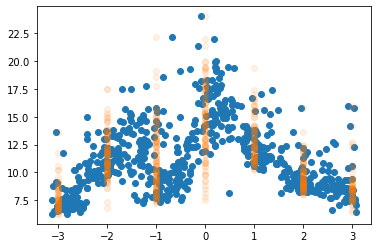

In [23]:
np.round(df.query('pulse_binary == True').phase)
plt.scatter(df.query('pulse_binary == True').phase,'signal',data = df.query('pulse_binary == True'))
plt.scatter(np.round(df.query('pulse_binary == True').phase),'signal',data = df.query('pulse_binary == True'),alpha=.1)

plt.show()


In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def classify_phase(phase,n_clusters = 6,random_state = 42, max_iter = 300, n_init = 20):
    # performs k-means clustering on phase to estimate density of 
    # intensity values across phase. 
    # input 
    features = np.vstack([phase]).T
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    kmeans = KMeans(
        init="random",
        n_clusters=n_clusters,
        n_init=n_init,
        max_iter=max_iter,
        random_state=random_state
    )

    kmeans.fit(scaled_features)

    return kmeans.labels_

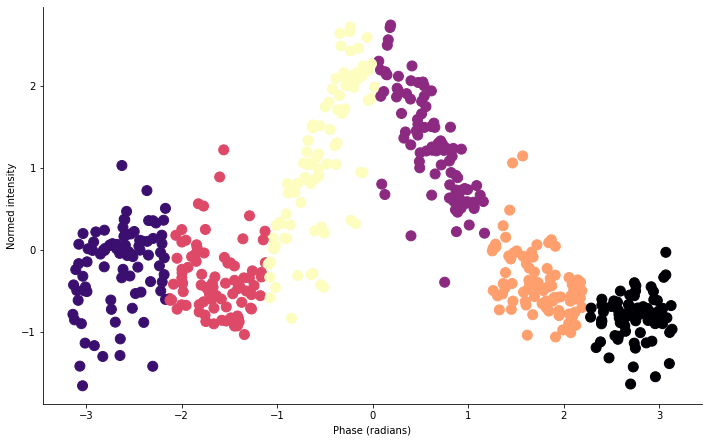

In [32]:
fig = plt.figure(figsize = set_size('thesis',2,(1,1)))
# ax = fig.add_subplot(projection='polar')

labels_ = classify_phase(df['phase'])
plt.scatter('phase','norm_signal',data = df,c = labels_, cmap = 'magma',s=100 )
plt.ylabel('Normed intensity')
plt.xlabel('Phase (radians)')
sns.despine()
plt.show()

# custom_plots.circular_hist(ax, df.phase,bins =32)

### Examine 2s average of raw intensity signal

In [68]:
from MCE.preprocessing import main

data_path = "//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/old_data/fiji/"
files = glob.glob(data_path+"*.csv")

df = pd.DataFrame()
# process fiji data
for file in files: 
    basename = os.path.basename(file)
    temp = main.run(file,save = False, metadata_path = r"Y:\laura_berkowitz\cardiac_grant\burst_data\meta_data.csv")
    df = df.append(temp,ignore_index=True)

C:\Users\schafferlab\AppData\Local\Temp\ipykernel_16888\2409265018.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp,ignore_index=True)
C:\Users\schafferlab\AppData\Local\Temp\ipykernel_16888\2409265018.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp,ignore_index=True)
C:\Users\schafferlab\AppData\Local\Temp\ipykernel_16888\2409265018.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp,ignore_index=True)


In [69]:
df

,time,signal,time_after_burst,pulse_binary,norm_signal,phase,filt_sig,mouse,diet,sex,video_name,burst,kmeans_labels,round_labels
0,0.013889,8.587,-6.750000,True,-0.905056,1.639,-0.051604,[711],chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,b4,3,2.0
1,0.027778,7.963,-6.736111,True,-1.094200,2.394,-0.863631,[711],chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,b4,4,2.0
2,0.041667,7.776,-6.722222,True,-1.150882,-2.838,-1.103561,[711],chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,b4,1,-3.0
3,0.055556,10.773,-6.708333,True,-0.242446,-2.114,-0.627805,[711],chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,b4,1,-2.0
4,0.069444,12.385,-6.694444,True,0.246175,-1.314,0.408136,[711],chow,m,__711_b4_72-2021-10-26-21-38-10_1.avi,b4,0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,12.040000,3.651,5.700000,True,-0.689691,-1.761,-0.298605,[734],HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,50fps-2021-11-09-17-46-55,3,-2.0
2122,12.060000,5.921,5.720000,True,1.038012,-0.691,1.257664,[734],HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,50fps-2021-11-09-17-46-55,5,-1.0
2123,12.080000,5.997,5.740000,True,1.095856,0.369,1.343776,[734],HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,50fps-2021-11-09-17-46-55,0,0.0
2124,12.100000,3.431,5.760000,True,-0.857133,1.349,0.220247,[734],HFpEF,m,_734_burst4_50fps-2021-11-09-17-46-55_1.avi,50fps-2021-11-09-17-46-55,0,1.0


In [76]:
df.keys()

Index(['time', 'signal', 'time_after_burst', 'pulse_binary', 'norm_signal',
       'phase', 'filt_sig', 'mouse', 'diet', 'sex', 'video_name', 'burst',
       'kmeans_labels', 'round_labels'],
      dtype='object')

<Figure size 720x360 with 0 Axes>

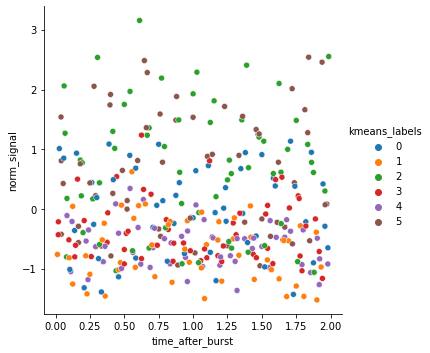

In [72]:
# fig = plt.figure(figsize=set_size('thesis', fraction=.1, subplots=(1, 1)))
fig = plt.figure(figsize=(10,5))
sns.relplot(data = df[(df["time_after_burst"] > 0) & (df["time_after_burst"] < 2)], 
            x = "time_after_burst",
            y = "norm_signal",
            hue = "kmeans_labels",
            palette = "tab10",
            kind = "scatter")



# sns.boxplot(data = df[(df["time after burst"] > 0) & (df["time after burst"] < 2)],
#             x = "diet",
#             y = "norm_signal",
#             hue = "mouse",
#             palette = "tab10",
#             )
# sns.pointplot(x="time after burst", y="norm_signal", hue = "mouse",data= df[(df["time after burst"] > 0) & (df["time after burst"] < 2)])
# color = 
# for mouse in np.unique(df["mouse"]):
    
#     temp = df[(df["mouse"] == mouse) & (df["time after burst"] > 0)]
#     signal = gaussian_filter(temp["norm_signal"],5)
#     plt.plot(temp["time after burst"],signal,linewidth=5)
#     plt.plot(temp["time after burst"],temp["norm_signal"])

#     # bins = np.arange(0, np.max(temp["time after burst"]),2)
    # binned_signal
    # sns.pointplot(data = temp, np.histogram(temp["norm_signal"],bins)[0])


# sns.boxplot(data = df[(df["time after burst"] > 0)],
#             x = "time after burst",
#             y = "norm_signal",
#             hue = "mouse")

# sns.replot()

In [542]:
df_proc = pd.read_csv("C:/Users/schafferlab/Desktop/711_b4_sanitycheck.csv")
df_proc.columns = df_proc.columns.str.replace(' ','')
df_proc

,Slice,time,ROI1,ROI2,ROI3,avg
0,491,6.819444,10.82927,7.41858,13.46331,10.570387
1,500,6.944444,11.81559,7.99938,14.89536,11.570110
2,517,7.180556,11.91353,7.27905,13.44412,10.878900
3,552,7.666667,13.53326,7.91899,15.60108,12.351110
4,561,7.791667,17.65041,9.51770,21.04505,16.071053
5,587,8.152778,19.79934,11.67555,23.17694,18.217277
6,630,8.750000,19.87491,11.67534,23.16873,18.239660
7,656,9.111111,19.03049,10.31674,20.41749,16.588240
8,734,10.194444,19.76922,12.48167,21.13885,17.796580
9,760,10.555556,17.50314,11.33694,18.18762,15.675900


[ 1.31630636e+00  1.91389256e+01 -7.16630589e+04]


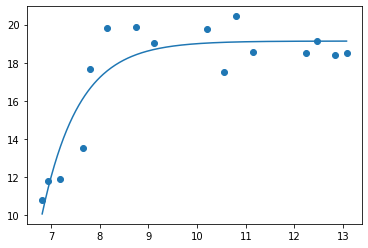

In [534]:
from scipy.optimize import curve_fit 
from scipy.stats import expon

def func(x,a,b,c):
    return (b-c) * (1 - np.exp(-a*x)) + c

x = np.linspace(np.min(df_proc["time"]),np.max(df_proc["time"]),300)

popt,pcov = curve_fit(func,df_proc["time"],df_proc["ROI1"])
y_pred = func(x,*popt)
print(popt)

plt.scatter(df_proc["time"],df_proc["ROI1"])
plt.plot(x,y_pred)


### Plot all available data of posterior wall intensity following pulse

C:\Users\schafferlab\AppData\Local\Temp\ipykernel_16888\2125588088.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1, 1)))


<Figure size 106.299x65.6965 with 0 Axes>

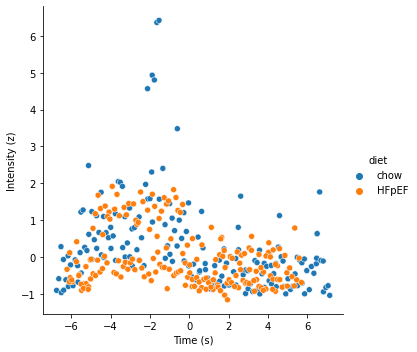

<Figure size 106.299x65.6965 with 0 Axes>

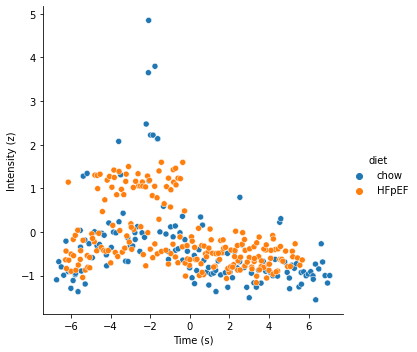

<Figure size 106.299x65.6965 with 0 Axes>

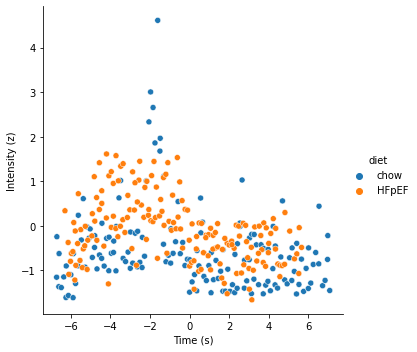

<Figure size 106.299x65.6965 with 0 Axes>

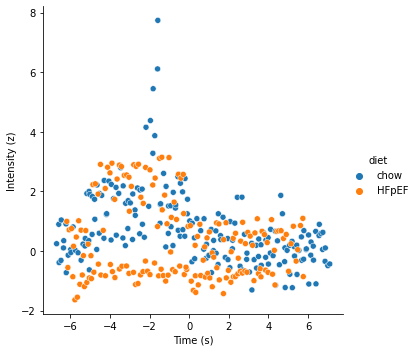

<Figure size 106.299x65.6965 with 0 Axes>

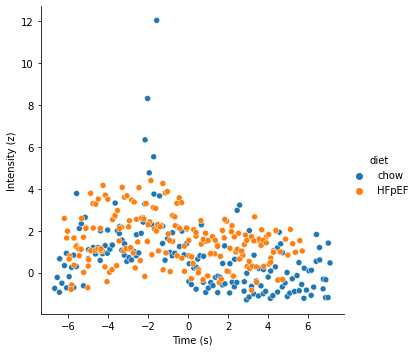

<Figure size 106.299x65.6965 with 0 Axes>

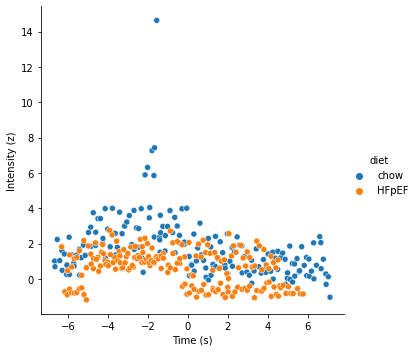

<Figure size 106.299x65.6965 with 0 Axes>

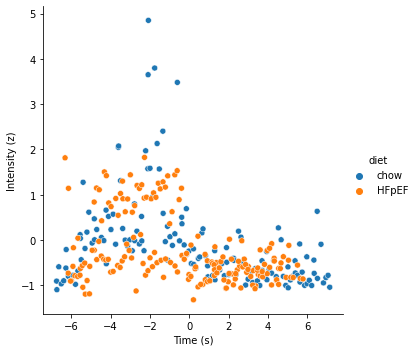

<Figure size 106.299x65.6965 with 0 Axes>

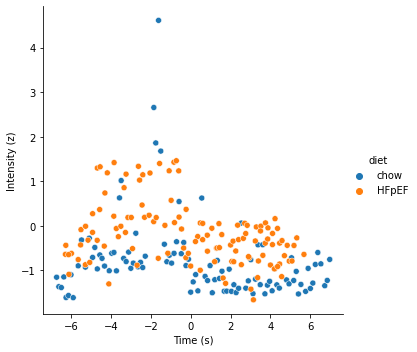

<Figure size 106.299x65.6965 with 0 Axes>

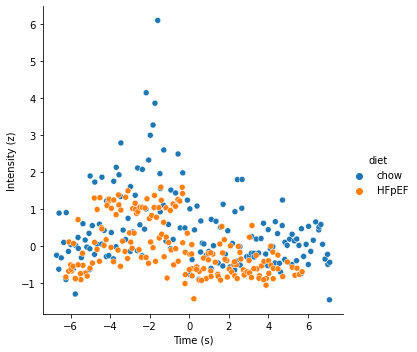

<Figure size 106.299x65.6965 with 0 Axes>

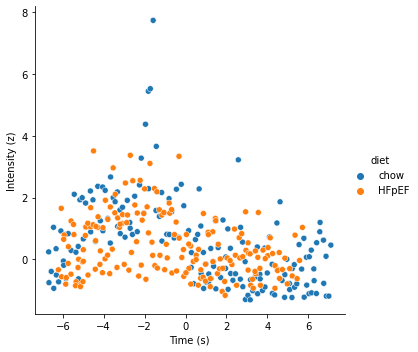

<Figure size 106.299x65.6965 with 0 Axes>

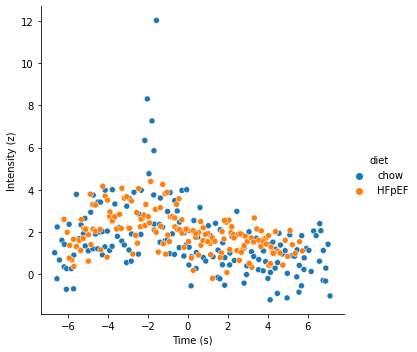

<Figure size 106.299x65.6965 with 0 Axes>

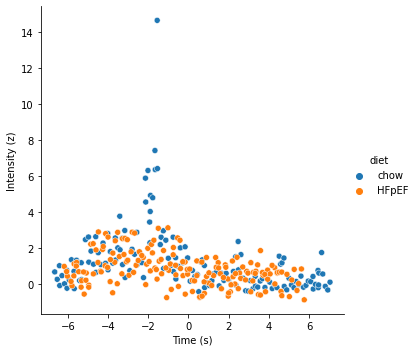

<Figure size 106.299x65.6965 with 0 Axes>

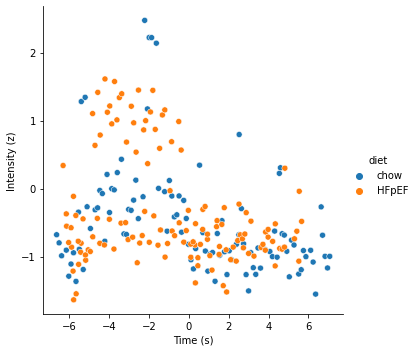

In [79]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from MCE.utils import functions

data_path = '//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/contrast_image_intensity/'
files = glob.glob(data_path+'*.csv')
    
def func(x,a,b,c):
    return (b-c) * (1 - np.exp(-a*x)) + c

polyreg=make_pipeline(PolynomialFeatures(2),LinearRegression())

# df = pd.DataFrame()
# for file in files:
#     temp_df = pd.read_csv(file)
#     df = df.append(temp_df,ignore_index=True)


for label in df.kmeans_labels.unique():

    fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1, 1)))
    sns.relplot(data = df[df['kmeans_labels'] == label], 
                x = "time_after_burst",
                y = "norm_signal",
                hue = 'diet',
                palette = "tab10")

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity (z)')

for label in df.round_labels.unique():

    fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1, 1)))
    sns.relplot(data = df[df['round_labels'] == label], 
                x = "time_after_burst",
                y = "norm_signal",
                hue = 'diet',
                palette = "tab10")

    plt.xlabel('Time (s)')
    plt.ylabel('Intensity (z)')

# # plot fit
# for mouse in np.unique(df["mouse"]):
#     # X = df[df.mouse_id == mouse].time.values.reshape(-1, 1)
#     # y = df[df.mouse_id == mouse].roi_1.values
#     # X_seq = np.linspace(X.min(),X.max(),16).reshape(-1,1)

#     # polyreg.fit(X,y)
#     # plt.plot(X_seq,polyreg.predict(X_seq))
        
#     try: 
#         x = np.linspace(np.min(df["time"][df.mouse_id == mouse]),np.max(df["time"][df.mouse_id == mouse]),300)
#         popt,pcov = curve_fit(func,df["time"][df.mouse_id == mouse],df["roi_1"][df.mouse_id == mouse])
#         y_pred = func(x,*popt)
#         plt.plot(x,y_pred)
#     except: 
#         x = np.linspace(np.min(df["time"][df.mouse_id == mouse]),np.max(df["time"][df.mouse_id == mouse]),300).reshape(-1,1)
#         X = df[df.mouse_id == mouse].time.values.reshape(-1, 1)
#         y = df[df.mouse_id == mouse].roi_1.values
#         polyreg.fit(X,y)
#         plt.plot(x,polyreg.predict(x))

#     plt.savefig(save_path+"PW_intensity_across_mice.svg",dpi = 300, bbox_inches = "tight")



In [64]:
df.keys()

Index(['time', 'signal', 'time_after_burst', 'pulse_binary', 'norm_signal',
       'phase', 'filt_sig', 'mouse', 'diet', 'sex', 'video_name', 'burst'],
      dtype='object')

In [16]:
# convert time to time after burst 
metadata = pd.read_csv("//10.253.5.16/sn data server 3/laura_berkowitz/cardiac_grant/burst_data/meta_data.csv")
metadata[(metadata.mouse_id == 711) | (metadata.mouse_id == 734) | (metadata.mouse_id == 733)]



,diet,video_file,sex,mouse_id,frame_rate,frame_after_burst,frame_before_burst
6,chow,__711_b1_44-2021-10-26-21-35-11_1.avi,m,711,44.0,NaN,NaN
7,chow,__711_b2_44-2021-10-26-21-35-52_1.avi,m,711,44.0,NaN,NaN
8,chow,__711_b3_72_zoomed-2021-10-26-21-36-21_1.avi,m,711,72.0,487.0,113.0
9,chow,__711_b4_72-2021-10-26-21-38-10_1.avi,m,711,72.0,486.0,113.0
10,chow,__711_b5_72_zoomed-2021-10-26-21-39-24_1.avi,m,711,72.0,NaN,NaN
11,chow,__711_b6_38-2021-10-26-21-45-44_1.avi,m,711,38.0,NaN,NaN
12,chow,__711NOT_contrast_44-2021-10-26-21-02-20_1.avi,m,711,44.0,NaN,NaN
31,HFpEF,__733_burst1_48fps-2021-11-09-19-02-28_1.avi,m,733,48.0,295.0,59.0
32,HFpEF,__733_i2burst1_48fps-2021-11-09-19-08-01_1.avi,m,733,48.0,298.0,62.0
33,HFpEF,__733_i2burst2_48fps-2021-11-09-19-08-34_1.avi,m,733,48.0,NaN,NaN


In [683]:
(77.5*2) + (104*2) + (13*4)

415.0